ref: https://adventuresinmachinelearning.com/reinforcement-learning-tutorial-python-keras/

In [16]:
import gym
import gym_toytext
import numpy as np

In [5]:
env = gym.make('NChain-v0')

In [6]:
env.reset()

0

In [7]:
env.step(1)

(0, 2, False, {})

The tuple represents the following:

* The new state after the action
* The reward due to the action
* Whether the game is “done” or not – the NChain game is done after 1,000 steps
* Debugging information – not relevant in this exampleThe new state after the action

In [8]:
# step(0) = move forward
# step(1) = move backwards
env.step(0)

(1, 0, False, {})

In [9]:
env.step(0)

(2, 0, False, {})

In [10]:
env.step(0)

(3, 0, False, {})

In [11]:
env.step(0)

(4, 0, False, {})

In [12]:
env.step(0)

(4, 10, False, {})

In [13]:
env.step(0)
# Unlucky, it switched to a backward step and sent me to the starting state (0).

(0, 2, False, {})

## A first naive heuristic for reinforcement learning

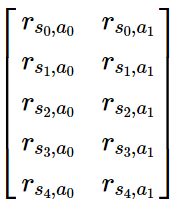

Each of the rows corresponds to the 5 available states in the NChain environment, and each column corresponds to the 2 available actions in each state – forward and backward, 0 and 1.

The value in each of these table cells corresponds to some measure of reward that the agent has “learnt” occurs when they are in that state and perform that action. So, the value $r_{s_0,a_0}$ would be, say, the sum of the rewards that the agent has received when in the past they have been in state 0 and taken action 0.

In [17]:
def naive_sum_reward_agent(env, num_episodes=500):
    # this is the table that will hold our summated rewards for
    # each action in each state
    r_table = np.zeros((5, 2))
    for g in range(num_episodes):
        s = env.reset()   # Start a new game. The value of s will be 0.
        done = False
        while not done:
            if np.sum(r_table[s, :]) == 0:  # check to see if the sum across the row is equal to zero (this will only be the case very early in the loop before numbers are recorded)
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with highest cummulative reward
                a = np.argmax(r_table[s, :])
            new_s, r, done, _ = env.step(a)
            r_table[s, a] += r
            s = new_s
    return r_table

In [20]:
naive_sum_reward_agent(env, num_episodes=500)

array([[     0., 638852.],
       [     0., 127972.],
       [     0.,  25798.],
       [     0.,   5140.],
       [     0.,   3088.]])

In [21]:
# The model picked action 1 in all states because it wants the immediate reward.

# See below on how to address this.

## Delayed reward reinforcement learning

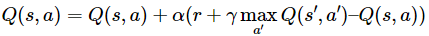

In [22]:
def q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95  # gamma; "patience"; decreases the impact of future rewards
    lr = 0.8  # alpha; learning rate; restricts the updating to ensure it doesn’t “race” to a solution; important for optimal convergence
    for i in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            if np.sum(q_table[s,:]) == 0:
                # make a random selection of actions
                a = np.random.randint(0, 2)
            else:
                # select the action with largest q value in state s
                a = np.argmax(q_table[s, :])
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr*(y*np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

In [23]:
q_learning_with_table(env, num_episodes=500)

array([[ 0.        , 25.89772487],
       [25.71170783,  0.        ],
       [ 0.        , 26.31658991],
       [ 0.        , 28.93264839],
       [32.18463022,  0.        ]])

In [ ]:
# Something has clearly gone wrong – and the answer is that there isn’t enough exploration going on within the agent training method.

## Q learning with $\epsilon$-greedy action selection

If we think about the previous iteration of the agent training model using Q learning, the action selection policy is based solely on the maximum Q value in any given state. It is conceivable that, given the random nature of the environment, that the agent initially makes “bad” decisions. The Q values arising from these decisions may easily be “locked in” – and from that time forward, bad decisions may continue to be made by the agent because it can only ever select the maximum Q value in any given state, even if these values are not necessarily optimal. This action selection policy is called a greedy policy.

So we need a way for the agent to eventually always choose the “best” set of actions in the environment, yet at the same time allowing the agent to not get “locked in” and giving it some space to explore alternatives. What is required is the $\epsilon$-greedy policy.

The $\epsilon$-greedy policy in reinforcement learning is basically the same as the greedy policy, except that there is a value $\epsilon$ (which may be set to decay over time) where, if a random number is selected which is less than this value, an action is chosen completely at random. This step allows some random exploration of the value of various actions in various states, and can be scaled back over time to allow the algorithm to concentrate more on exploiting the best strategies that it has found. This mechanism can be expressed in code as:

In [25]:
def eps_greedy_q_learning_with_table(env, num_episodes=500):
    q_table = np.zeros((5, 2))
    y = 0.95
    eps = 0.5
    lr = 0.8
    decay_factor = 0.999
    for i in range(num_episodes):
        s = env.reset()
        eps *= decay_factor
        done = False
        while not done:
            # select the action with highest cummulative reward
            if np.random.random() < eps or np.sum(q_table[s, :]) == 0:   # np.random.random() returns a random float between 0 and 1
                a = np.random.randint(0, 2)
            else:
                a = np.argmax(q_table[s, :])
            # pdb.set_trace()
            new_s, r, done, _ = env.step(a)
            q_table[s, a] += r + lr * (y * np.max(q_table[new_s, :]) - q_table[s, a])
            s = new_s
    return q_table

In [27]:
eps_greedy_q_learning_with_table(env, num_episodes=500)

array([[51.47061258, 44.50002847],
       [47.19598889, 48.9389892 ],
       [47.75186168, 61.24361596],
       [51.86305512, 39.07831795],
       [80.23387036, 45.41148705]])

## Comparing the methods

Let’s see if the last agent training model actually produces an agent that gathers the most rewards in any given game. 

In [28]:
def test_methods(env, num_iterations=100):
    winner = np.zeros((3,))
    for g in range(num_iterations):
        m0_table = naive_sum_reward_agent(env, 500)
        m1_table = q_learning_with_table(env, 500)
        m2_table = eps_greedy_q_learning_with_table(env, 500)
        m0 = run_game(m0_table, env)
        m1 = run_game(m1_table, env)
        m2 = run_game(m2_table, env)
        w = np.argmax(np.array([m0, m1, m2]))
        winner[w] += 1
        print("Game {} of {}".format(g + 1, num_iterations))
    return winner

In [29]:
def run_game(table, env):
    s = env.reset()
    tot_reward = 0
    done = False
    while not done:
        a = np.argmax(table[s, :])
        s, r, done, _ = env.step(a)
        tot_reward += r
    return tot_reward

In [30]:
test_methods(env, num_iterations=100)

Game 1 of 100
Game 2 of 100
Game 3 of 100
Game 4 of 100
Game 5 of 100
Game 6 of 100
Game 7 of 100
Game 8 of 100
Game 9 of 100
Game 10 of 100
Game 11 of 100
Game 12 of 100
Game 13 of 100
Game 14 of 100
Game 15 of 100
Game 16 of 100
Game 17 of 100
Game 18 of 100
Game 19 of 100
Game 20 of 100
Game 21 of 100
Game 22 of 100
Game 23 of 100
Game 24 of 100
Game 25 of 100
Game 26 of 100
Game 27 of 100
Game 28 of 100
Game 29 of 100
Game 30 of 100
Game 31 of 100
Game 32 of 100
Game 33 of 100
Game 34 of 100
Game 35 of 100
Game 36 of 100
Game 37 of 100
Game 38 of 100
Game 39 of 100
Game 40 of 100
Game 41 of 100
Game 42 of 100
Game 43 of 100
Game 44 of 100
Game 45 of 100
Game 46 of 100
Game 47 of 100
Game 48 of 100
Game 49 of 100
Game 50 of 100
Game 51 of 100
Game 52 of 100
Game 53 of 100
Game 54 of 100
Game 55 of 100
Game 56 of 100
Game 57 of 100
Game 58 of 100
Game 59 of 100
Game 60 of 100
Game 61 of 100
Game 62 of 100
Game 63 of 100
Game 64 of 100
Game 65 of 100
Game 66 of 100
Game 67 of 100
Game

array([20., 12., 68.])

So far, we have been dealing with explicit tables to hold information about the best actions and which actions to choose in any given state. However, while this is perfectly reasonable for a small environment like NChain, the table gets far too large and unwieldy for more complicated environments which have a huge number of states and potential actions.

This is where neural networks can be used in reinforcement learning. Instead of having explicit tables, instead we can train a neural network to predict Q values for each action in a given state. This will be demonstrated using Keras in the next section.

## Reinforcement learning with Keras

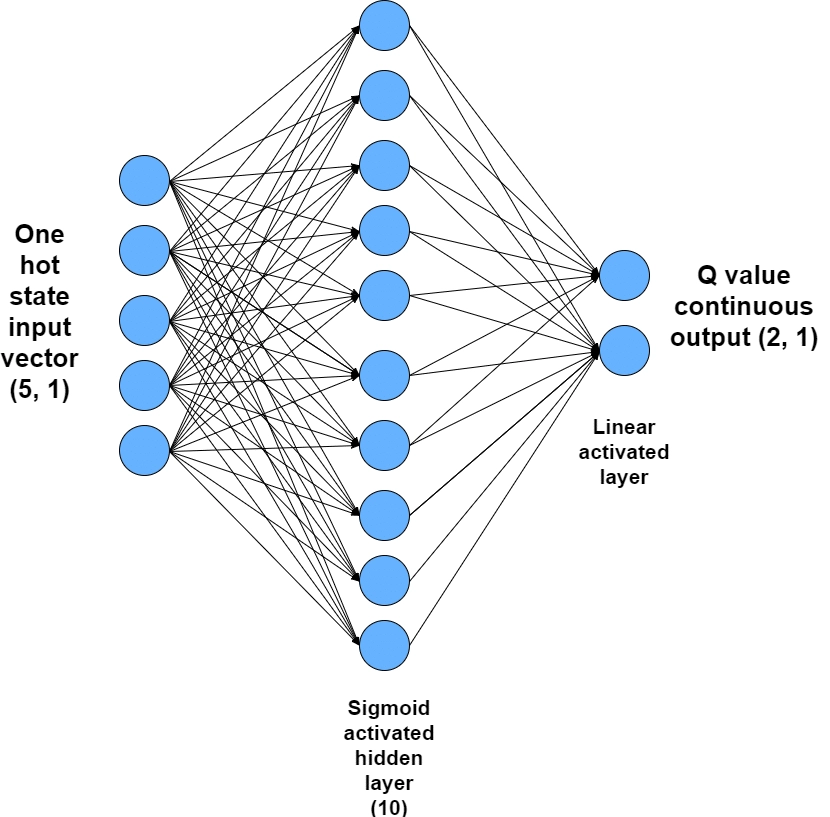

The input to the network is the one-hot encoded state vector. For instance, the vector which corresponds to state 1 is [0, 1, 0, 0, 0] and state 3 is [0, 0, 0, 1, 0]. In this case, a hidden layer of 10 nodes with sigmoid activation will be used. The output layer is a linear activated set of two nodes, corresponding to the two Q values assigned to each state to represent the two possible actions. Linear activation means that the output depends only on the linear summation of the inputs and the weights, with no additional function applied to that summation.

In [37]:
import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

In [38]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(1, 5)))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [39]:
# now execute the q learning
y = 0.95
eps = 0.5
decay_factor = 0.999
num_episodes = 1000
r_avg_list = []
for i in range(num_episodes):
    s = env.reset()
    eps *= decay_factor
    if i % 100 == 0:
        print("Episode {} of {}".format(i + 1, num_episodes))
    done = False
    r_sum = 0
    while not done:
        if np.random.random() < eps:
            a = np.random.randint(0, 2)
        else:
            a = np.argmax(model.predict(np.identity(5)[s:s + 1]))
        new_s, r, done, _ = env.step(a)
        target = r + y * np.max(model.predict(np.identity(5)[new_s:new_s + 1]))
        target_vec = model.predict(np.identity(5)[s:s + 1])[0]
        target_vec[a] = target
        model.fit(np.identity(5)[s:s + 1], target_vec.reshape(-1, 2), epochs=1, verbose=0)
        s = new_s
        r_sum += r
    r_avg_list.append(r_sum / 1000)

Episode 1 of 1000


KeyboardInterrupt: 